In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import arviz as az
import os
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

In [ ]:
anomalies_path = '/content/drive/MyDrive/anomaly.csv'
anomaly_data = pd.read_csv(anomalies_path)

In [ ]:
data_path = '/content/drive/MyDrive/sample2_totest.csv'
datao = pd.read_csv(data_path)


In [ ]:
anomaly_data.head()

,Key,Date,Anomaly
0,8001_Commercial_ from other categories,2019-01-01,0
1,8001_Commercial_ from other categories,2019-01-02,0
2,8001_Commercial_ from other categories,2019-01-03,0
3,8001_Commercial_ from other categories,2019-01-04,0
4,8001_Commercial_ from other categories,2019-01-05,0


In [ ]:
datao.head()

,PCode,Muni,Date,Use,EconAct,NumMeters,ConsLDay,spi_12,spi_9,scpdsi,...,DeathRate,LifeExp,NumChild,UnempRate,EmpRate,ActRate,ServEmp,IndEmp,Area,ChildCare
0,8001,BARCELONA,2019-01-01,Commercial,from other categories,21,24015.0,1.59,1.2,2.59,...,10.38,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65
1,8001,BARCELONA,2019-01-02,Commercial,from other categories,21,21925.0,1.59,1.2,2.59,...,10.38,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65
2,8001,BARCELONA,2019-01-03,Commercial,from other categories,21,23348.0,1.59,1.2,2.59,...,10.38,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65
3,8001,BARCELONA,2019-01-04,Commercial,from other categories,21,19795.0,1.59,1.2,2.59,...,10.38,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65
4,8001,BARCELONA,2019-01-05,Commercial,from other categories,21,21985.0,1.59,1.2,2.59,...,10.38,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65


In [ ]:
def split_key(row):
    pcode, use, activity = row['Key'].split('_')
    return pd.Series([pcode, use, activity])

anomaly_data[['PCode', 'Use', 'EconAct']] = anomaly_data.apply(split_key, axis=1)
anomaly_data = anomaly_data.drop(columns=['Key'])
anomaly_data['PCode'] = anomaly_data['PCode'].astype('int64')


In [ ]:
anomaly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     2922 non-null   object
 1   Anomaly  2922 non-null   int64 
 2   PCode    2922 non-null   int64 
 3   Use      2922 non-null   object
 4   EconAct  2922 non-null   object
dtypes: int64(2), object(3)
memory usage: 114.3+ KB


In [ ]:
anomalydf = datao.merge(anomaly_data, on=['PCode', 'Use', 'EconAct', 'Date'], how='left')


In [ ]:
anomalydf.tail()

,PCode,Muni,Date,Use,EconAct,NumMeters,ConsLDay,spi_12,spi_9,scpdsi,...,LifeExp,NumChild,UnempRate,EmpRate,ActRate,ServEmp,IndEmp,Area,ChildCare,Anomaly
2917,8005,BARCELONA,2022-12-27,Commercial,from other categories,84,57587.0,-1.32,-1.57,-2.98,...,83.76,0.97,6.97,93.12,58.48,92.78,3.22,100.76,67.53,0
2918,8005,BARCELONA,2022-12-28,Commercial,from other categories,84,63247.0,-1.32,-1.57,-2.98,...,83.76,0.97,6.97,93.12,58.48,92.78,3.22,100.76,67.53,0
2919,8005,BARCELONA,2022-12-29,Commercial,from other categories,84,67008.0,-1.32,-1.57,-2.98,...,83.76,0.97,6.97,93.12,58.48,92.78,3.22,100.76,67.53,0
2920,8005,BARCELONA,2022-12-30,Commercial,from other categories,84,72452.0,-1.32,-1.57,-2.98,...,83.76,0.97,6.97,93.12,58.48,92.78,3.22,100.76,67.53,0
2921,8005,BARCELONA,2022-12-31,Commercial,from other categories,84,54535.0,-1.32,-1.57,-2.98,...,83.76,0.97,6.97,93.12,58.48,92.78,3.22,100.76,67.53,0


# PatternRecognition

In [ ]:
anomalydf.head(5)


,PCode,Muni,Date,Use,EconAct,NumMeters,ConsLDay,spi_12,spi_9,scpdsi,...,LifeExp,NumChild,UnempRate,EmpRate,ActRate,ServEmp,IndEmp,Area,ChildCare,Anomaly
0,8001,BARCELONA,2019-01-01,Commercial,from other categories,21,24015.0,1.59,1.2,2.59,...,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65,0
1,8001,BARCELONA,2019-01-02,Commercial,from other categories,21,21925.0,1.59,1.2,2.59,...,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65,0
2,8001,BARCELONA,2019-01-03,Commercial,from other categories,21,23348.0,1.59,1.2,2.59,...,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65,0
3,8001,BARCELONA,2019-01-04,Commercial,from other categories,21,19795.0,1.59,1.2,2.59,...,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65,0
4,8001,BARCELONA,2019-01-05,Commercial,from other categories,21,21985.0,1.59,1.2,2.59,...,83.57,1.08,9.19,90.88,58.5,91.21,4.27,102.76,66.65,0


In [ ]:
# Define the target column
target_variable = "Anomaly"

# Define the numerical variables # Remove 'RowNumber', 'CustomerId', 'Surname', 'Exited'
num_variables = [c for c, dt in anomalydf.dtypes.items() if dt in (np.int64, np.float64) and c not in ['PCode','Year','Month','Day','Anomaly']]
#num_variables = [e for e in num_variables if e not in ['RowNumber','CustomerId','Surname','Exited']]

# Define the categorical ones # Remove 'RowNumber', 'CustomerId', 'Surname', 'Exited'
categorical_variables = [c for c in anomalydf.columns if c not in num_variables and c not in ['PCode','Year','Month','Day','Anomaly', 'Date']]
#categorical_variables = [e for e in categorical_variables if e not in ['RowNumber','CustomerId','Surname','Exited']]

In [ ]:
categorical_variables

['Muni', 'Use', 'EconAct']

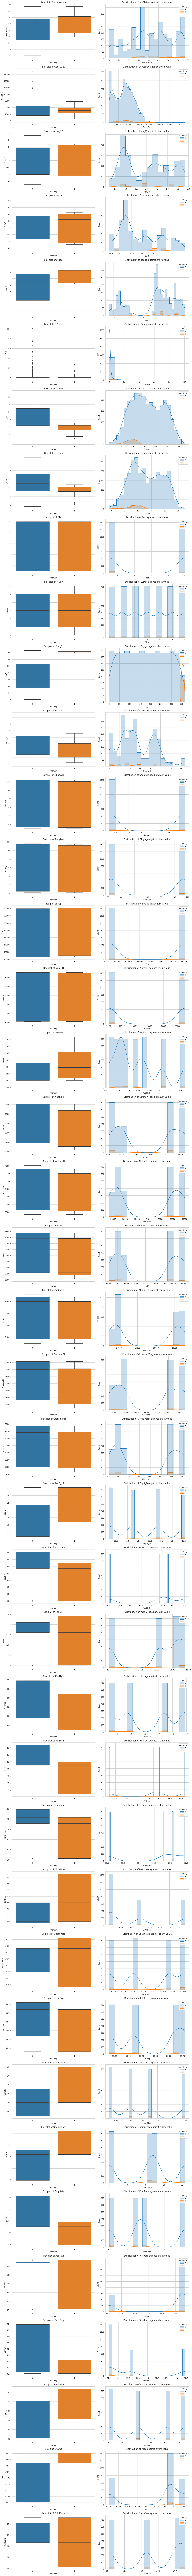

In [ ]:
data = anomalydf
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Determine the number of rows and columns for the subplot grid
num_vars = len(num_variables)
cols = 2  # Two plots for each variable: boxplot and distribution plot
rows = num_vars  # One row for each variable

# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Box plots and distribution plots for numerical variables
for i, column in enumerate(num_variables):
    sns.boxplot(x='Anomaly', y=column, data=data, ax=axs[i, 0])
    axs[i, 0].set_title(f'Box plot of {column}')

    sns.histplot(data=data, x=column, hue='Anomaly', kde=True, element='step', ax=axs[i, 1])
    axs[i, 1].set_title(f'Distribution of {column} against churn value')

# Adjust layout
plt.tight_layout()
plt.show()

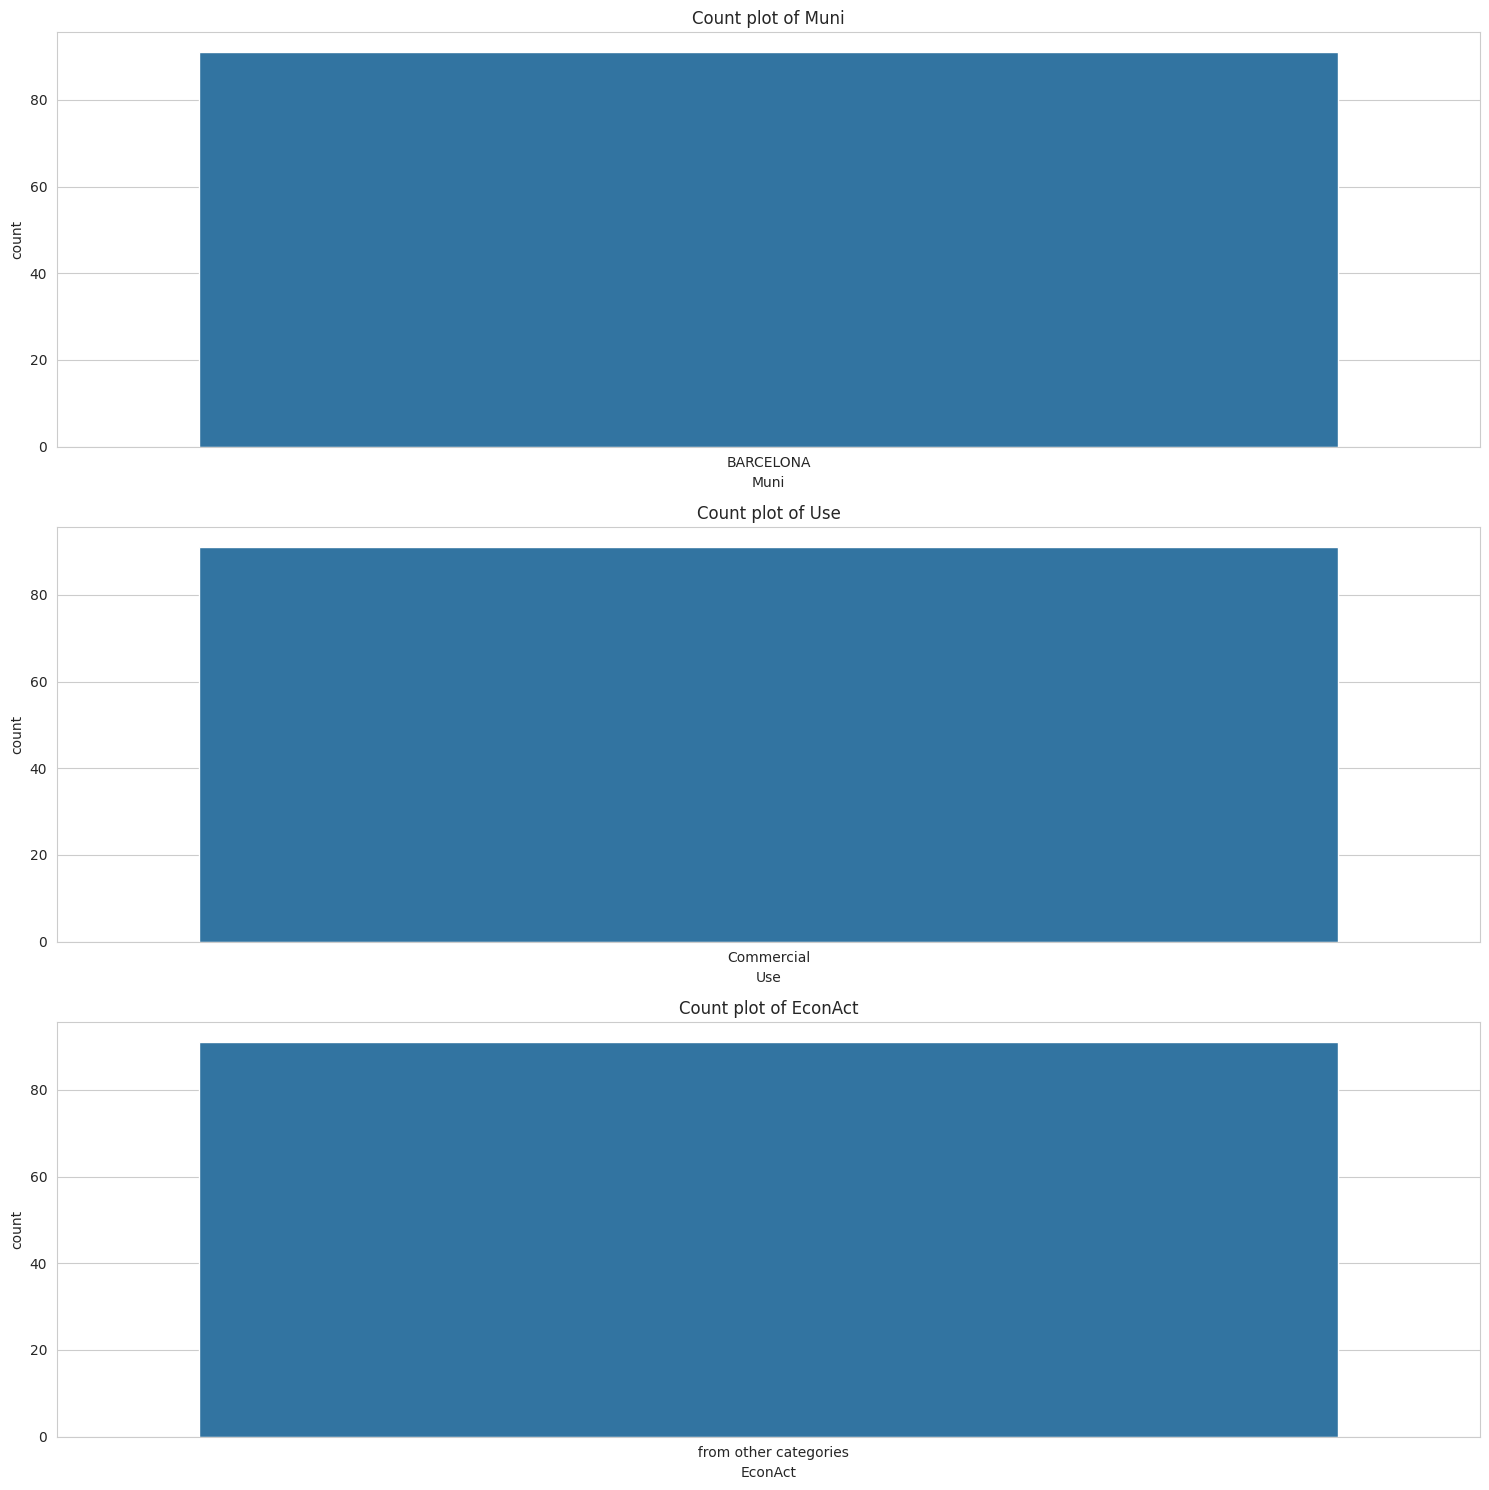

In [ ]:
data = anomalydf[anomalydf['Anomaly'] ==1]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Determine the number of rows and columns for the subplot grid
cat_vars = len(categorical_variables)
rows = cat_vars  # One row for each variable

# Create a figure
fig, axs = plt.subplots(rows, 1, figsize=(15, 5*rows))

# Box plots and distribution plots for numerical variables
for i, column in enumerate(categorical_variables):
    # Get the top 5 categories in the current column
    top_5_categories = data[column].value_counts().index[:5]

    # Filter the data for only the top 5 categories
    filtered_data = data[data[column].isin(top_5_categories)]

    # Create the countplot
    sns.countplot(x=column, data=filtered_data, ax=axs[i])
    axs[i].set_title(f'Count plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

# Anomalies Clusterization

In [ ]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

In [ ]:
num_variables

['NumMeters',
 'ConsLDay',
 'spi_12',
 'spi_9',
 'scpdsi',
 'Precip',
 'T_max',
 'T_min',
 'Dist',
 'WDay',
 'Day_Yr',
 'Price_m2',
 'ShopAge',
 'BldgAge',
 'Pop',
 'NumHH',
 'AvgPPHH',
 'NetIncPP',
 'NetIncHH',
 'IncPC',
 'MedIncPC',
 'GrossIncPP',
 'GrossIncHH',
 'Pop0_14',
 'Pop15_64',
 'Pop65_',
 'MedAge',
 'ForBorn',
 'Foreigners',
 'BirthRate',
 'DeathRate',
 'LifeExp',
 'NumChild',
 'UnempRate',
 'EmpRate',
 'ActRate',
 'ServEmp',
 'IndEmp',
 'Area',
 'ChildCare']

In [ ]:
# Create a PCA object
pca = PCA(n_components=3)  # Change this to the number of components you want

data=data.dropna()
# Fit and transform the data
data_pca = pca.fit_transform(data[num_variables])


# Convert the array to a DataFrame
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Now 'data_pca_df' is a DataFrame with the principal components
data_pca_df.head()

,PC1,PC2,PC3
0,-73156.060690,-15065.484986,-460.292485
1,-73414.103687,-5891.104786,145.311549
2,-73609.501540,1056.009709,603.892638
3,-73611.297018,1119.845411,608.107630
4,-73500.931599,-2804.052203,349.092054


In [ ]:
# Get the loadings
loadings = pca.components_

# Convert the loadings to a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings, columns=num_variables, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

loadings_df.head()

,NumMeters,ConsLDay,spi_12,spi_9,scpdsi,Precip,T_max,T_min,Dist,WDay,...,DeathRate,LifeExp,NumChild,UnempRate,EmpRate,ActRate,ServEmp,IndEmp,Area,ChildCare
PC1,0.000159,0.028054,4.630962e-07,1.660783e-07,5.545918e-07,1.829935e-07,-0.000001,-0.000002,0.000062,-4.797916e-07,...,-1.140474e-08,-3.437709e-08,-1.663313e-08,7.041695e-07,-6.687902e-07,-3.859607e-07,1.119952e-08,-8.296043e-08,-1.332703e-07,4.233684e-07
PC2,-0.000263,-0.997432,4.685370e-05,4.587126e-05,4.251595e-05,9.871582e-06,-0.000021,-0.000026,0.000002,-3.954561e-06,...,2.932772e-06,-4.923992e-06,5.234025e-07,3.491664e-05,-3.317005e-05,-2.397101e-05,-7.706402e-06,7.390642e-06,-5.864102e-07,4.640834e-05
PC3,0.006543,-0.065841,-5.690667e-04,-6.310418e-04,-5.166651e-04,-1.435749e-03,-0.000035,-0.000366,-0.000006,-3.083932e-05,...,-4.632115e-05,6.357985e-05,-1.213714e-05,-3.287861e-04,3.123810e-04,2.515603e-04,1.167413e-04,-1.311058e-04,-2.667700e-05,-5.728912e-04


In [ ]:
anomaly_scatter= go.Scatter3d(
                        x = data_pca_df.PC1,
                        y = data_pca_df.PC2,   #rellenar con los tres parametros mas importantes si los sabemos
                        z = data_pca_df.PC3,    #con pca se puede saber, coger codigo de statistical analysis
                        mode = 'markers',
                        opacity = 0.7,
                        name = "Anomalies",
                        marker = dict(size = 3)
)


'''
anomaly_scatter= go.Scatter3d(
                        x = data['Population'],
                        y = data['Consumption (L/Day)'],   #rellenar con los tres parametros mas importantes si los sabemos
                        z = data['T_max (C)'],    #con pca se puede saber, coger codigo de statistical analysis
                        mode = 'markers',
                        opacity = 0.7,
                        name = "Anomalies",
                        marker = dict(size = 3)
)
'''


list_3d = [anomaly_scatter]

fig_3d = go.Figure(data = list_3d)
iplot(fig_3d)

In [ ]:
X = data_pca_df.values
print(X)

[[-7.31560607e+04 -1.50654850e+04 -4.60292485e+02]
 [-7.34141037e+04 -5.89110479e+03  1.45311549e+02]
 [-7.36095015e+04  1.05600971e+03  6.03892638e+02]
 [-7.36112970e+04  1.11984541e+03  6.08107630e+02]
 [-7.35009316e+04 -2.80405220e+03  3.49092054e+02]
 [-7.35166139e+04 -2.24648747e+03  3.85890557e+02]
 [-7.33199536e+04 -9.23848609e+03 -7.56464966e+01]
 [-7.32195475e+04 -1.28082954e+04 -3.11284822e+02]
 [-7.33649807e+04 -7.63760746e+03  3.00352409e+01]
 [-7.35328573e+04 -1.66897377e+03  4.24028269e+02]
 [-7.36725675e+04  3.29823795e+03  7.51915784e+02]
 [-7.39514268e+04  1.32127125e+04  1.40637109e+03]
 [-7.37138073e+04  4.76446319e+03  8.48703209e+02]
 [-7.34230249e+04 -5.57391974e+03  1.66269240e+02]
 [-7.32513610e+04 -1.16772064e+04 -2.36607542e+02]
 [-7.32771990e+04 -1.07585713e+04 -1.75967203e+02]
 [-7.34224078e+04 -5.59586287e+03  1.64825542e+02]
 [-7.19426564e+04  1.45528851e+04 -7.65469451e+02]
 [-7.18851171e+04  1.25071520e+04 -9.00508036e+02]
 [-7.18660963e+04  1.18308932e+

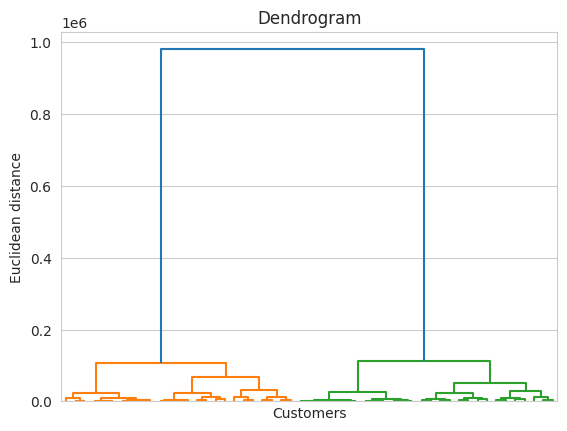

In [ ]:
X = data_pca_df.values
hier_clust=sch.linkage(X, method = 'ward')

dendrogram = sch.dendrogram(hier_clust, truncate_mode = 'level',
           p = 5,
           show_leaf_counts=True,
           no_labels= True)

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5,              #probar numero de clusters
                    affinity = 'euclidean',
                    linkage = 'ward')

y_hc = hc.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



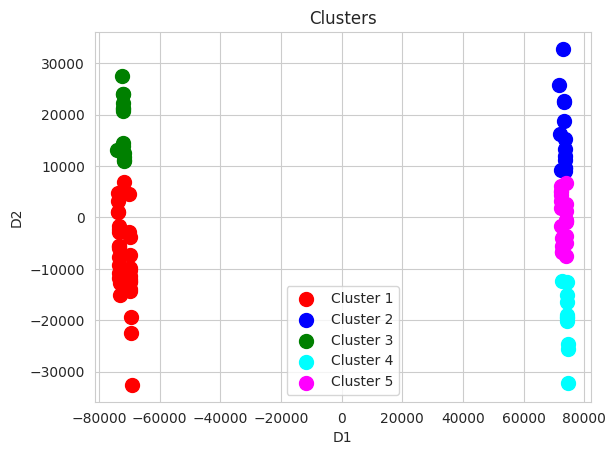

In [ ]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters')
plt.xlabel('D1')
plt.ylabel('D2')
plt.legend()
plt.show()

Si lo hacemos con PCA queda muy bonito pero no nos dice mucho, lo suyo seria extraer del PCA cuales son las variables principales y usarlas para el clusterization

# Old Code

In [ ]:
datasubset = data.sample(n=500, random_state=1)

In [ ]:
datasubset.head(5)

,Postcode,Municipality,Use,Type of economic activity,Number of meters,Consumption (L/Day),Precipitaciones (mm),T_max (C),T_min (C),spi_12,spi_9,scpdsi,Price per m2,Population,RFDB per inhabitant. Thousands of euros,% employment,Date
1073486,8901,L'HOSPITALET LLOBR.,Commercial,* retail tobacco jobs reality with maqu,4,1795.0,3.7,22.4,13.4,-1.22,-0.84,-1.55,12.9,265444.0,15.3,85.615,2022-05-05
2332335,8902,L'HOSPITALET LLOBR.,Commercial,Schools and services for improving sports,1,149.0,0.0,18.9,8.7,-0.07,-0.60,2.69,12.4,264657.0,15.3,85.615,2021-05-03
2773823,8905,L'HOSPITALET LLOBR.,Commercial,"Services in chocolate shops, ice cream shops ...",1,0.0,0.0,18.5,10.5,-0.64,-0.11,1.35,13.0,264923.0,15.9,85.615,2019-11-30
5167079,8840,VILADECANS,Commercial,* Plumbing facilities,1,489.0,6.3,12.9,10.5,-1.00,-0.69,-1.39,11.1,66720.0,17.1,87.910,2022-04-20
2173515,8902,L'HOSPITALET LLOBR.,Commercial,Extermination of harmful animals and disinfec...,2,288.0,0.6,24.5,18.1,0.45,-0.51,1.43,13.1,264923.0,15.9,85.615,2019-09-13


In [ ]:

def get_sample(row):
    # Filter the original dataset for matching criteria and earlier date
    filtered_data = data[(data['Postcode'] == row['Postcode']) &
                         (data['Municipality'] == row['Municipality']) &
                         (data['Use'] == row['Use']) &
                         (data['Type of economic activity'] == row['Type of economic activity']) &
                         (data['Number of meters'] == row['Number of meters']) &
                         (data['Date'] < row['Date'])]

    # Return a random sample from the filtered data
    return filtered_data.sample(1) if not filtered_data.empty else None

# Apply the function to each row in the new dataset
samples = datasubset.apply(get_sample, axis=1)

# Concatenate the resulting Series into a DataFrame
new_dataframe = pd.concat(samples.tolist())


In [ ]:
new_dataframe.head(5)

,Postcode,Municipality,Use,Type of economic activity,Number of meters,Consumption (L/Day),Precipitaciones (mm),T_max (C),T_min (C),spi_12,spi_9,scpdsi,Price per m2,Population,RFDB per inhabitant. Thousands of euros,% employment,Date
978879,8901,L'HOSPITALET LLOBR.,Commercial,* retail tobacco jobs reality with maqu,4,1162.0,0.0,24.9,15.6,-0.59,-0.84,2.23,12.4,264657.0,15.3,85.615,2021-06-06
2241257,8902,L'HOSPITALET LLOBR.,Commercial,Schools and services for improving sports,1,5.0,0.0,24.8,14.3,1.73,1.55,3.72,13.9,269382.0,15.3,85.615,2020-06-06
2765484,8905,L'HOSPITALET LLOBR.,Commercial,"Services in chocolate shops, ice cream shops ...",1,0.0,0.0,24.1,14.2,0.46,-0.62,1.17,13.0,264923.0,15.9,85.615,2019-10-08
5114783,8840,VILADECANS,Commercial,* Plumbing facilities,1,292.0,0.0,27.9,18.4,-1.14,-0.97,1.43,10.5,66707.0,17.1,87.910,2021-09-04
2132064,8902,L'HOSPITALET LLOBR.,Commercial,Extermination of harmful animals and disinfec...,2,1.0,0.0,23.4,12.3,0.57,0.22,1.54,13.0,264923.0,15.9,85.615,2019-03-23


In [ ]:
datasubset['anomaly'] = 1
new_dataframe['anomaly'] = 0

In [ ]:
anomalydf = pd.concat([datasubset,new_dataframe])